# Granularity in mixed-integer nonlinear optimization

## Summary of the document

This document is complementary to the paper "Granularity in mixed-integer nonlinear optimization". The intention is to make the numerical results transparent. The generated results for the IPCP, the feasibility pump as well as for B-Hyb are stored as pandas data-frames and are concatenated herein. 

The latex-tables of the article are produced by using the command print(dataframe.to_latex(float_format = '%.2f'))

In [48]:
import pandas as pd
pd.options.display.float_format = '${:,.2f}'.format
import numpy as np
import pickle
from ast import literal_eval

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def store_FRA_results_for_Bonmin(pseudo_granular_results):
    np.save('vals_SOR',np.array(pseudo_granular_results['obj']))
    testbed = list(pseudo_granular_results.index)
    with open(r'../testbed/SOR_succ.txt', 'w') as f:
        for item in testbed:
            f.write("%s\n" % item)
def load_successful_results(name):
    results = load_obj(name)
    succ_results = results[results['obj'] != float('inf')]
    print(len(succ_results)," Problems are pseudo granular")
    return succ_results

def load_problems_with_computable_Lipschitz_constant(name):
    results = load_obj(name)
    L_results = results.loc[results['time L']<=1800]
    print("We can compute Lipschitz constants for", len(L_results)," Problems")
    return L_results

def load_problems_with_time_limit_Lipschitz(name):
    results = load_obj(name)
    L_results = results.loc[results['time L']>1800]
    print("We can't compute Lipschitz constants for", len(L_results)," Problems")
    return L_results
    
def find_simple_problems(result_frame):
    constr_quadrouple = result_frame['constrs'].to_list()
    simple_problems = []
    for idx, quadrouple in enumerate(constr_quadrouple):
        if quadrouple[-6:-1] == ' 0, 0':
            simple_problems.append(result_frame.index[idx])
    return simple_problems

def filter_instances_from_A_not_contained_in_B(resA,resB):
    res_set = set(resA.index)
    res_set.difference_update(list(resB.index))
    res_list = list(res_set)
    res_list.sort()
    return res_list

def filter_instances_nonlinear_in_y(result):
    result_nonlinear = result[result['constrs'].apply(lambda x: int(x[-2]))>0]
    return result_nonlinear

def filter_out_only_epi_problems(result):
    result_nonepi = result[result['constrs']!='(1, 1, 1, 1)']
    return result_nonepi

def update_objective_value_epi_problems(result):
    epi_subset = result['constr_value'] != float('-inf') 
    result.loc[epi_subset,'obj'] = np.array(result[epi_subset]['obj']+result[epi_subset]['constr_value'])
    result = result.drop('constr_value',axis=1)
    return result

def print_numbers_of_different_problemclasses(results):
    class0 = 0
    class1 = 0
    class2 = 0
    for name in results.index.to_list():
        constr_tuple = literal_eval(results.loc[name].constrs)
        if constr_tuple[2] == 0:
            class0 +=1
        elif constr_tuple[3] == 0:
            class1 +=1
        else:
            class2 += 1
    print(class0,class1,class2)
    
def print_numbers_of_purely_epi_problems(results):
    epi_problems = 0
    for name in results.index.to_list():
        constr_array = np.array(literal_eval(results.loc[name].constrs))
        if all(constr_array == 1):
            epi_problems +=1
    print(epi_problems)
    
def delete_irrelevant_information_Lipschitz_table(results):
    for name in results.index.to_list():
        constr_array = np.array(literal_eval(results.loc[name,'constrs']))
        var_array = np.array(literal_eval(results.loc[name,'vars']))
        results.loc[name,'constrs'] = constr_array[0] - 1
        results.loc[name,'vars'] = var_array[0]-1

## Analysis of results
We tested FRA-SOR for $\delta \in \{0.5,0.75,0.9999\}$, with $\delta$ being the enlargement parameter for the box constraints. We found that most problems were granular for $\delta = 0.9999$ (even though Lipschitz constants were bigger). However, interestingly, we found that the larger the value of $\delta$, the more difficult the computation of Lipschitz constants (i.e. the longer the solver needed to solve the auxiliary problem).

Next, we report our main results with $\delta = 0.9999$.

In [57]:
for filename in ['SOR_all_instances_0.5','SOR_all_instances_0.75','SOR_all_instances_0.9999']:
    results_overall = load_obj(filename)
    results_L_computable = load_problems_with_computable_Lipschitz_constant(filename)
    results_pseudo_granular = load_successful_results(filename)
    results_L_not_computable = load_problems_with_time_limit_Lipschitz(filename)

We can compute Lipschitz constants for 197  Problems
42  Problems are pseudo granular
We can't compute Lipschitz constants for 13  Problems
We can compute Lipschitz constants for 184  Problems
41  Problems are pseudo granular
We can't compute Lipschitz constants for 26  Problems
We can compute Lipschitz constants for 183  Problems
52  Problems are pseudo granular
We can't compute Lipschitz constants for 27  Problems


In [58]:
store_FRA_results_for_Bonmin(results_pseudo_granular)

In [64]:
results_L_computable.loc[results_L_computable['time SOR']>1800]

,vars,constrs,time L,time SOR,obj,constr_value
gabriel09,"(1868, 756, 756)","(10088, 288, 0, 0)",$0.00,"$1,821.60",$inf,$-inf
ringpack_30_2,"(463, 403, 403)","(8768, 8303, 8303, 0)",$0.00,"$1,810.03",$inf,$-inf
smallinvSNPr3b010-011,"(101, 100, 0)","(4, 1, 1, 1)",$0.20,$inf,$inf,$0.00
smallinvSNPr3b020-022,"(101, 100, 0)","(4, 1, 1, 1)",$0.20,$inf,$inf,$0.00
smallinvSNPr3b050-055,"(101, 100, 0)","(4, 1, 1, 1)",$0.22,$inf,$inf,$0.00
smallinvSNPr3b100-110,"(101, 100, 0)","(4, 1, 1, 1)",$0.19,$inf,$inf,$0.00
smallinvSNPr3b150-165,"(101, 100, 0)","(4, 1, 1, 1)",$0.20,$inf,$inf,$0.00
smallinvSNPr3b200-220,"(101, 100, 0)","(4, 1, 1, 1)",$0.20,$inf,$inf,$0.00
sonet25v5,"(300, 300, 300)","(6925, 25, 25, 25)",$4.62,"$1,833.15",$inf,$-inf


So we obtain feasible points for 52 optimization problems with $\delta = 0.9999$. Let us initially analyze the difficulty of the auxiliary problem.

In [59]:
print_numbers_of_different_problemclasses(results_overall)
print_numbers_of_purely_epi_problems(results_overall)

68 10 132
24


### Lipschitz computation
Here, we analyse how much time the computation of Lipschitz constants take dependently on the problem-size. Let us start with problems where the Lipschitz constant is not computable

In [4]:
delete_irrelevant_information_Lipschitz_table(results_L_not_computable)

In [5]:
print(results_L_not_computable[['vars','constrs']].to_latex(float_format = '%.2f'))

\begin{tabular}{lrr}
\toprule
{} &  vars &  constrs \\
\midrule
edgecross14-058   &   182 &     1456 \\
edgecross14-098   &   182 &     1456 \\
edgecross14-117   &   182 &     1456 \\
edgecross14-137   &   182 &     1456 \\
edgecross20-040   &   380 &     4560 \\
edgecross20-080   &   380 &     4560 \\
edgecross22-048   &   462 &     6160 \\
edgecross22-096   &   462 &     6160 \\
edgecross24-057   &   552 &     8096 \\
edgecross24-115   &   552 &     8096 \\
faclay20h         &   190 &     2280 \\
faclay25          &   300 &     4600 \\
faclay30          &   435 &     8120 \\
faclay30h         &   435 &     8120 \\
faclay33          &   528 &    10912 \\
faclay35          &   595 &    13090 \\
sporttournament30 &   435 &        0 \\
sporttournament32 &   496 &        0 \\
sporttournament34 &   561 &        0 \\
sporttournament36 &   630 &        0 \\
sporttournament38 &   703 &        0 \\
sporttournament40 &   780 &        0 \\
sporttournament42 &   861 &        0 \\
sporttournament4

In [6]:
len(results_L_not_computable)

27

In [7]:
print(results_L_not_computable[['vars','constrs']].to_latex(float_format = '%.2f'))

\begin{tabular}{lrr}
\toprule
{} &  vars &  constrs \\
\midrule
edgecross14-058   &   182 &     1456 \\
edgecross14-098   &   182 &     1456 \\
edgecross14-117   &   182 &     1456 \\
edgecross14-137   &   182 &     1456 \\
edgecross20-040   &   380 &     4560 \\
edgecross20-080   &   380 &     4560 \\
edgecross22-048   &   462 &     6160 \\
edgecross22-096   &   462 &     6160 \\
edgecross24-057   &   552 &     8096 \\
edgecross24-115   &   552 &     8096 \\
faclay20h         &   190 &     2280 \\
faclay25          &   300 &     4600 \\
faclay30          &   435 &     8120 \\
faclay30h         &   435 &     8120 \\
faclay33          &   528 &    10912 \\
faclay35          &   595 &    13090 \\
sporttournament30 &   435 &        0 \\
sporttournament32 &   496 &        0 \\
sporttournament34 &   561 &        0 \\
sporttournament36 &   630 &        0 \\
sporttournament38 &   703 &        0 \\
sporttournament40 &   780 &        0 \\
sporttournament42 &   861 &        0 \\
sporttournament4

Below, we list the 10 interesting problems where the computation of all Lipschitz constants is possible and takes at least 10 seconds time

In [13]:
delete_irrelevant_information_Lipschitz_table(results_L_computable)

In [8]:
print(results_L_computable[results_L_computable['time L']>5][['vars','constrs','time L']].to_latex(float_format = '%.2f'))

\begin{tabular}{lllr}
\toprule
{} &             vars &          constrs &  time L \\
\midrule
edgecross10-040   &     (91, 90, 90) &   (481, 1, 1, 1) &   26.07 \\
edgecross10-050   &     (91, 90, 90) &   (481, 1, 1, 1) &   51.30 \\
edgecross10-070   &     (91, 90, 90) &   (481, 1, 1, 1) & 1095.94 \\
edgecross14-176   &  (183, 182, 182) &  (1457, 1, 1, 1) &  240.66 \\
sporttournament18 &  (154, 153, 153) &     (1, 1, 1, 1) &   10.09 \\
sporttournament20 &  (191, 190, 190) &     (1, 1, 1, 1) &   16.78 \\
sporttournament22 &  (232, 231, 231) &     (1, 1, 1, 1) &   22.01 \\
sporttournament24 &  (277, 276, 276) &     (1, 1, 1, 1) &  188.50 \\
sporttournament26 &  (326, 325, 325) &     (1, 1, 1, 1) &  229.13 \\
sporttournament28 &  (379, 378, 378) &     (1, 1, 1, 1) &  470.54 \\
\bottomrule
\end{tabular}



Interestingly, as mentioned above, for enlargement parameter $\delta = 0.5$, we can compute Lipschitz constants even for larger problems. Below, we list all 14 problems where we get a Lipschitz constant for $\delta = 0.5$, but not for $\delta = 0.9999$

In [41]:
results_L_computable_05 = load_problems_with_computable_Lipschitz_constant('SOR_all_instances_0.5')
Lipschitz_possible_only_05 = filter_instances_from_A_not_contained_in_B(results_L_computable_05,results_L_computable)
delete_irrelevant_information_Lipschitz_table(results_L_computable_05)
print(results_L_computable_05.loc[Lipschitz_possible_only_05][['vars','constrs','time L']].to_latex(float_format = "%.2f"))

We can compute Lipschitz constants for 197  Problems
\begin{tabular}{lrrr}
\toprule
{} &  vars &  constrs &  time L \\
\midrule
edgecross14-058   &   182 &     1456 &  520.04 \\
edgecross20-040   &   380 &     4560 &    1.97 \\
edgecross22-048   &   462 &     6160 &    3.33 \\
edgecross24-057   &   552 &     8096 &   14.20 \\
faclay20h         &   190 &     2280 &  147.93 \\
sporttournament30 &   435 &        0 &   10.39 \\
sporttournament32 &   496 &        0 &   14.07 \\
sporttournament34 &   561 &        0 &   87.50 \\
sporttournament36 &   630 &        0 &  154.60 \\
sporttournament38 &   703 &        0 &  283.53 \\
sporttournament40 &   780 &        0 &  363.55 \\
sporttournament42 &   861 &        0 & 1141.05 \\
sporttournament46 &  1035 &        0 &  946.42 \\
sporttournament48 &  1128 &        0 &  782.45 \\
\bottomrule
\end{tabular}



### Feasible points
Let us now investigate the problems for which we get a feasible point. We found that several problems which are originally unconstrained problems, but have been remodelled using the epigraph reformulation. We leave out such problems in our analysis, as the point obtained by FRA-SOR then corresponds to solving the unconstrained problem and rounding the optimal point. 

In [25]:
results_pseudo_granular

,vars,constrs,time L,time SOR,obj,constr_value
autocorr_bern20_03,"(21, 20, 20)","(1, 1, 1, 1)",$0.13,$0.09,$68.01,$-132.01
autocorr_bern25_03,"(26, 25, 25)","(1, 1, 1, 1)",$0.11,$0.08,$62.02,$-150.02
cvxnonsep_normcon20r,"(40, 10, 0)","(21, 20, 10, 10)",$1.16,$0.05,$-14.65,$-inf
cvxnonsep_normcon30r,"(60, 15, 0)","(31, 30, 15, 15)",$1.75,$0.06,$-14.80,$-inf
ex1223a,"(7, 4, 4)","(9, 4, 4, 0)",$0.00,$0.08,$6.07,$-inf
ex4,"(36, 25, 25)","(30, 25, 25, 0)",$0.00,$0.05,$-6.70,$-inf
genpooling_lee1,"(49, 9, 9)","(82, 20, 0, 0)",$0.00,$0.70,"$-4,309.83",$-inf
genpooling_lee2,"(53, 9, 9)","(92, 30, 0, 0)",$0.00,$0.34,"$-3,849.24",$-inf
genpooling_meyer10,"(394, 187, 187)","(423, 33, 0, 0)",$0.00,$0.74,"$5,129,659.13",$-inf
genpooling_meyer15,"(734, 352, 352)","(768, 48, 0, 0)",$0.00,$1.33,"$6,581,050.03",$-inf


In [10]:
results_nonepi = filter_out_only_epi_problems(results_pseudo_granular)
result_nonepi_post_processed = update_objective_value_epi_problems(results_nonepi)

C:\Users\hg2412\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
store_FRA_results_for_Bonmin(result_nonepi_post_processed)

### Comparison with bonmin for the above problems

In [11]:
res_bonmin = load_obj('res_bonmin')

In [23]:
overview = pd.concat([result_nonepi_post_processed,res_bonmin['time_bonmin']],axis=1)
order = ['vars','constrs', 'obj','time L', 'time SOR', 'time_bonmin']
modified_overview = overview[order]
print(modified_overview.to_latex(float_format = '%.2f'))
#modified_overview

\begin{tabular}{lllrrrr}
\toprule
{} &             vars &                constrs &         obj &  time L &  time SOR &  time\_bonmin \\
\midrule
cvxnonsep\_normcon20r  &      (40, 10, 0) &       (21, 20, 10, 10) &      -14.65 &    1.16 &      0.05 &         0.17 \\
cvxnonsep\_normcon30r  &      (60, 15, 0) &       (31, 30, 15, 15) &      -14.80 &    1.75 &      0.06 &         0.09 \\
ex1223a               &        (7, 4, 4) &           (9, 4, 4, 0) &        6.07 &    0.00 &      0.08 &         0.09 \\
ex4                   &     (36, 25, 25) &        (30, 25, 25, 0) &       -6.70 &    0.00 &      0.05 &         0.70 \\
genpooling\_lee1       &       (49, 9, 9) &         (82, 20, 0, 0) &    -4309.83 &    0.00 &      0.70 &         0.62 \\
genpooling\_lee2       &       (53, 9, 9) &         (92, 30, 0, 0) &    -3849.24 &    0.00 &      0.34 &         1.42 \\
genpooling\_meyer10    &  (394, 187, 187) &        (423, 33, 0, 0) &  5129659.13 &    0.00 &      0.74 &         3.33 \\
genpooling

In [18]:
SOR_better= np.where(modified_overview['time L']+ modified_overview['time SOR']< modified_overview['time_bonmin'])[0]
modified_overview.iloc[SOR_better,:]

,vars,constrs,obj,time L,time SOR,time_bonmin
ex1223a,"(7, 4, 4)","(9, 4, 4, 0)",$6.07,$0.00,$0.08,$0.09
ex4,"(36, 25, 25)","(30, 25, 25, 0)",$-6.70,$0.00,$0.05,$0.70
genpooling_lee2,"(53, 9, 9)","(92, 30, 0, 0)","$-3,849.24",$0.00,$0.34,$1.42
genpooling_meyer10,"(394, 187, 187)","(423, 33, 0, 0)","$5,129,659.13",$0.00,$0.74,$3.33
genpooling_meyer15,"(734, 352, 352)","(768, 48, 0, 0)","$6,581,050.03",$0.00,$1.33,$13.56
ndcc12,"(644, 46, 46)","(237, 46, 0, 0)",$108.11,$0.00,$0.14,$1.81
ndcc13,"(630, 42, 42)","(254, 42, 0, 0)",$107.57,$0.00,$0.25,$6.34
ndcc14,"(864, 54, 54)","(305, 54, 0, 0)",$143.31,$0.00,$0.62,$41.07
ndcc15,"(680, 40, 40)","(306, 40, 0, 0)",$102.42,$0.00,$0.28,$4.51
ndcc16,"(1080, 60, 60)","(377, 60, 0, 0)",$145.89,$0.00,$0.28,$42.33


In [19]:
print("Sor valuable in", len(modified_overview.iloc[SOR_better,:]), 
      "cases, Bonmin better in", len(modified_overview) - len(modified_overview.iloc[SOR_better,:]), "cases")

Sor valuable in 28 cases, Bonmin better in 11 cases


## Plot cumulative distribution function

In [20]:
from matplotlib import pyplot as plt
import re
from matplotlib import rc
%matplotlib inline

In [21]:
time_SOR = np.array(modified_overview['time L']+ modified_overview['time SOR'])
time_Bonmin = np.array(modified_overview['time_bonmin'])
time_SOR.sort()
time_Bonmin.sort()

C:\Users\hg2412\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


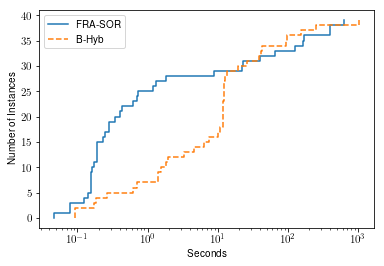

In [22]:
rc('text', usetex=True)
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('xtick', labelsize=11)
rc('ytick', labelsize=11)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.step(np.concatenate([time_SOR, time_SOR[[-1]]]), np.arange(time_SOR.size+1), label='FRA-SOR')
ax.step(np.concatenate([time_Bonmin, time_Bonmin[[-1]]]), np.arange(time_Bonmin.size+1), label='B-Hyb', linestyle = '--')
ax.legend()
ax.set_xlabel('Seconds')
ax.set_ylabel('Number of Instances')

fig.savefig('CDF.pdf', bbox_inches='tight')

## Comparison with $\delta = 0.75$

In [20]:
filename = 'SOR_all_instances_0.75'
results_pseudo_granular_075 = load_successful_results(filename)
results_nonepi_075 = filter_out_only_epi_problems(results_pseudo_granular_075)
result_nonepi_post_processed_075 = update_objective_value_epi_problems(results_nonepi_075)

41  Problems are pseudo granular


C:\Users\hg2412\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [34]:
com_obj = pd.concat([result_nonepi_post_processed_075['obj'],result_nonepi_post_processed['obj']],axis=1)
com_obj.columns = ['0.75','0.9999']
com_obj = com_obj.dropna()
print(sum(com_obj["0.75"]<com_obj["0.9999"]))
print(sum(com_obj["0.75"]>com_obj["0.9999"]))
print(sum(com_obj["0.75"]==com_obj["0.9999"]))

13
8
6


C:\Users\hg2412\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [35]:
com_obj

,0.75,0.9999
cvxnonsep_normcon20r,$-15.61,$-14.65
cvxnonsep_normcon30r,$-15.44,$-14.80
ex1223a,$6.07,$6.07
ex4,$-6.37,$-6.70
genpooling_lee1,"$-3,726.09","$-4,309.83"
genpooling_lee2,"$-2,971.29","$-3,759.46"
genpooling_meyer10,"$6,017,292.88","$5,504,875.19"
genpooling_meyer15,"$7,660,072.55","$6,544,066.67"
ndcc12,$108.11,$108.11
ndcc14,$143.31,$143.31
